170498071/170498071 [==============================] - 2s 0us/step


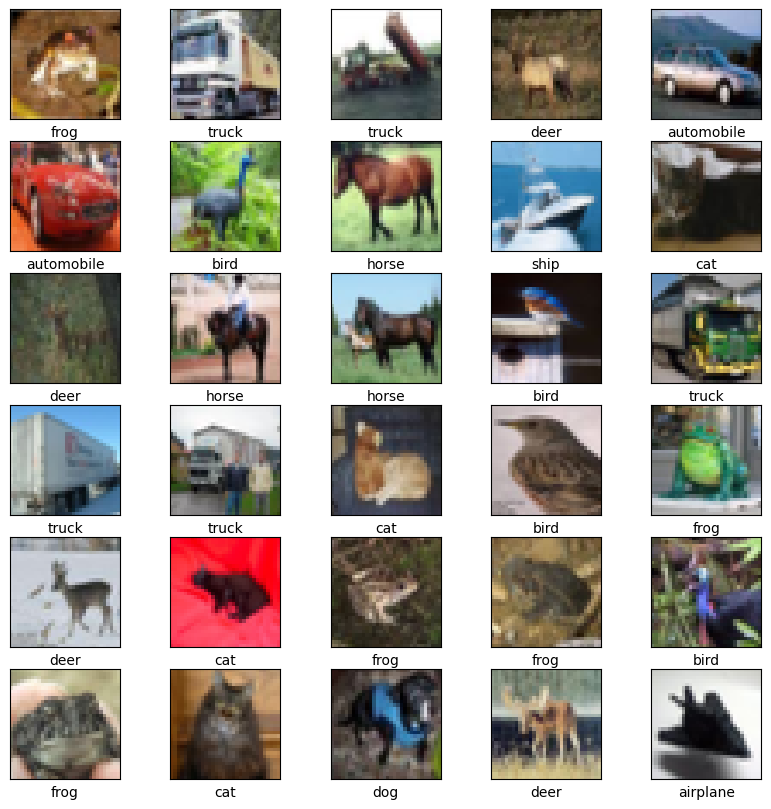

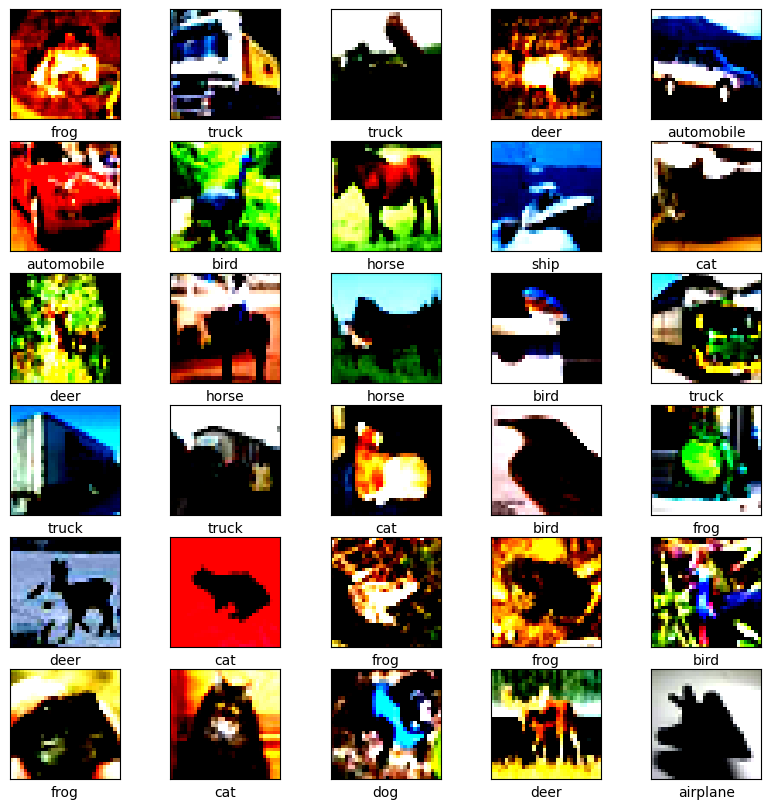

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/30
200/200 [==============================] - 147s 519ms/step - loss: 1.8171 - accuracy: 0.3543 - val_loss: 1.1660 - val_accuracy: 0.5973 - lr: 1.0000e-04
Epoch 2/30
200/200 [==============================] - 100s 502ms/step - loss: 0.9038 - accuracy: 0.6951 - val_loss: 0.7226 - val_accuracy: 0.7499 - lr: 1.0000e-04
Epoch 3/30
200/200 [==============================] - 99s 494ms/step - loss: 0.6669 - accuracy: 0.7764 - val_loss: 0.5656 - val_accuracy: 0.8080 - lr: 1.0000e-04
Epoch 4/30
200/200 [==============================] - 100s 500ms/step - loss: 0.5538 - accuracy: 0.8176 - val_loss: 0.5116 - val_accuracy: 0.8283 - lr: 1.0000e-04
Epoch 5/30
200/200 [==============================] - 97s 486ms/step - loss: 0.4759 - accuracy: 0.8414 - val_loss: 0.4640 - val_accuracy: 0.8465 - lr: 1.0000e-04
Epoch 6/30
200/200 [==============================] - 100s 499ms/step - loss: 0.4246 - accuracy: 0.8572 - val_loss: 0.4354

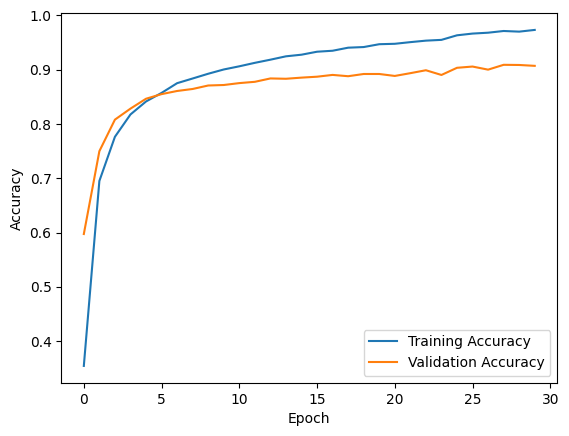

313/313 [==============================] - 8s 18ms/step
Precision: 0.7470559891650924
Recall: 0.6025


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

cifar100 = tf.keras.datasets.cifar10
(x_train, Y_train), (x_test, Y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train_resized = tf.image.resize(x_train, [75, 75])
x_test_resized = tf.image.resize(x_test, [75, 75])


y_train, y_test = Y_train.flatten(), Y_test.flatten()

data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    samplewise_std_normalization=True,
    samplewise_center=True,
    validation_split=0.2
)

batch_size = 200

train_generator = data_generator.flow(
    x_train_resized,
    tf.keras.utils.to_categorical(y_train, num_classes=10),
    batch_size=batch_size,
    subset='training'
)

val_generator = data_generator.flow(
    x_train_resized,
    tf.keras.utils.to_categorical(y_train, num_classes=10),
    batch_size=batch_size,
    subset='validation'
)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[Y_train[i][0]])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.image.per_image_standardization(x_train[i]))
    plt.xlabel(class_names[Y_train[i][0]])
plt.show()

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred_prob = model.predict(x_test_resized)

y_pred = np.argmax(y_pred_prob, axis=1)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
